ID: 63
Spain
23


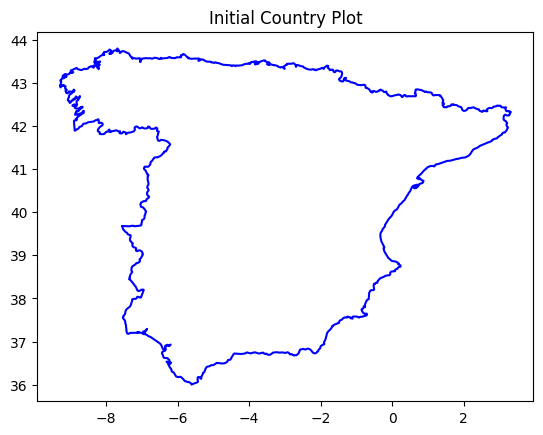

Wavelet ranges: [0.0 - 52.043884868495354]


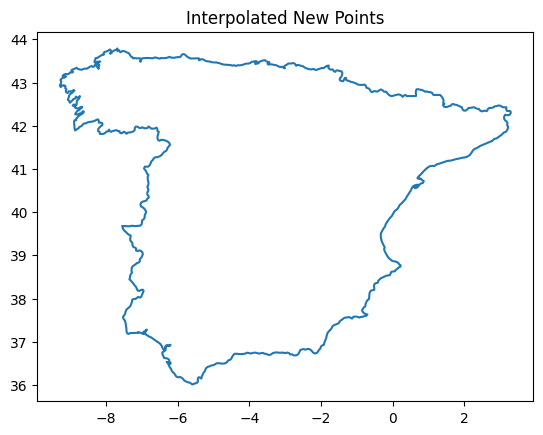

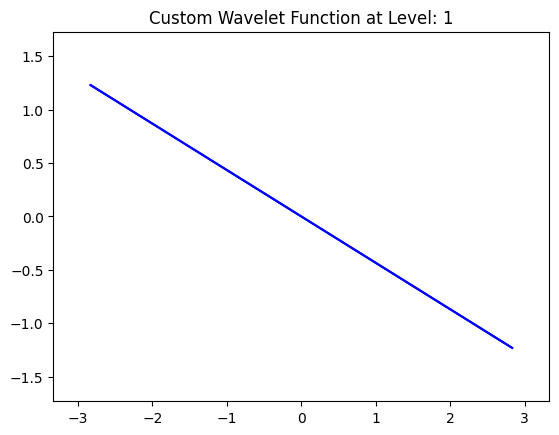

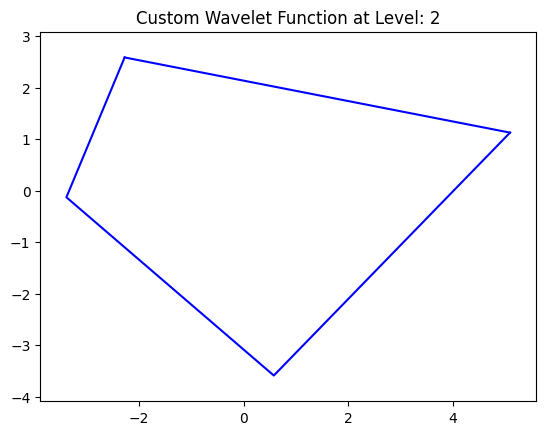

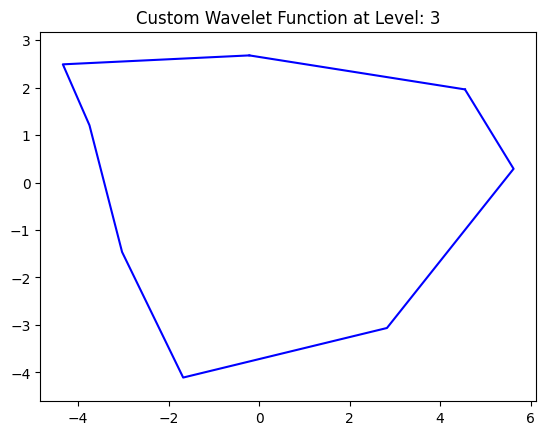

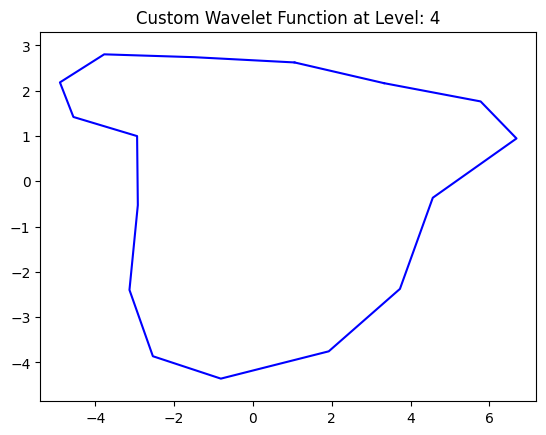

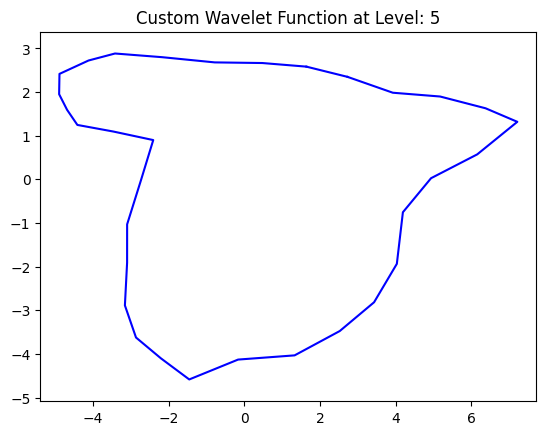

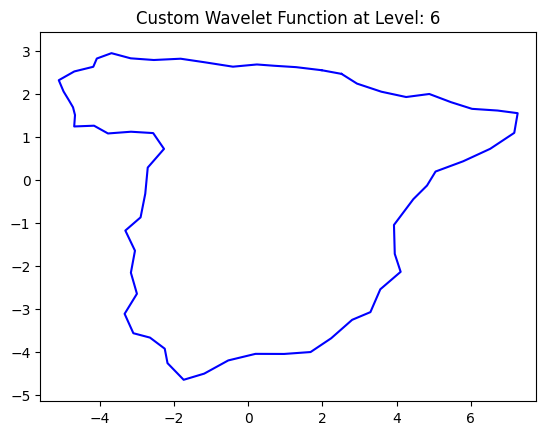

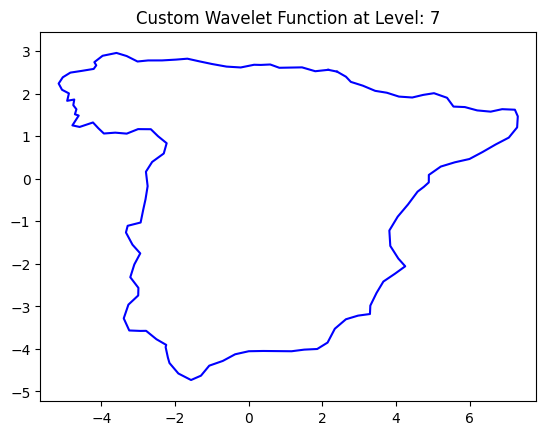

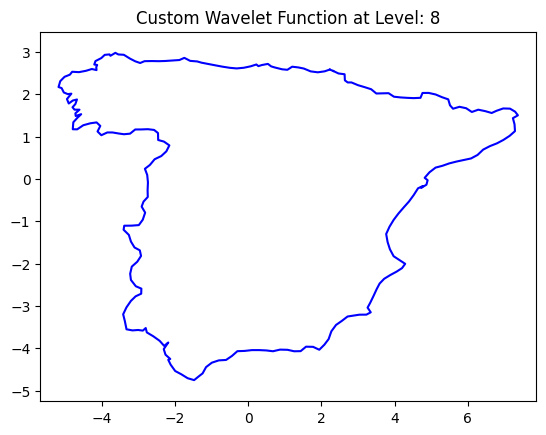

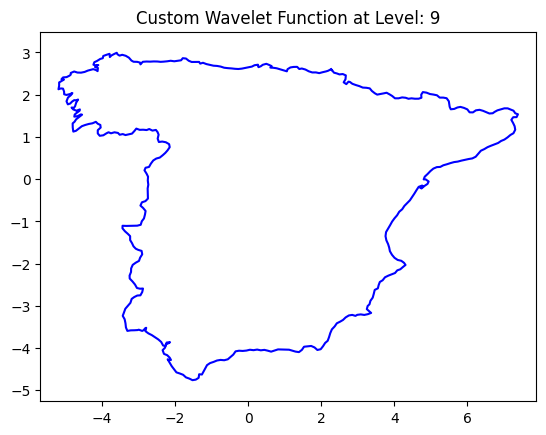

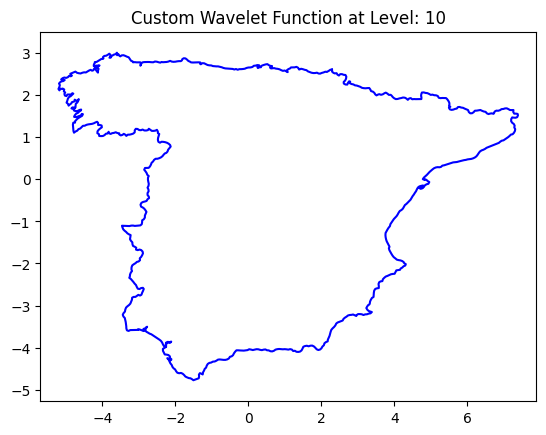

In [2]:
import matplotlib.pyplot as plt
import shapefile
import numpy as np
from shapely import geometry

def custom_wavelet_reconstruction(x, j, k, a, b): 
    eps = 1e-9
    xtld = (x - a) / (b - a)
    xx = np.power(2, j) * xtld - k
    h = np.power(2, j / 2) * (np.sign(xx + eps) + np.sign(xx - 1 - eps) - 2 * np.sign(xx - 0.5)) / (2 * (b - a))
    return h

def custom_pyramid_algorithm(ValueArray, NL, a, b):
    details = []
    smooth = (b - a) * ValueArray * 2 ** (-NL / 2)
    for i in range(NL):
        smooth_temp = (smooth[::2] + smooth[1::2]) / np.sqrt(2)
        details.append((smooth[::2] - smooth[1::2]) / np.sqrt(2))
        smooth = smooth_temp
    return smooth, details

shape = shapefile.Reader("./ne_10m_admin_0_countries_esp.shp")
id_val = -1
for i in range(len(shape)):
    feature = shape.shapeRecords()[i]
    if feature.record.NAME_EN == "Spain":
        id_val = i
        break

if id_val == -1:
    print("Country not found")
else:
    print("ID: " + str(id_val))

feature = shape.shapeRecords()[id_val]
print(feature.record.NAME_EN)
largestAreaID = 0
if feature.shape.__geo_interface__['type'] == 'MultiPolygon':
    print(len(feature.shape.__geo_interface__['coordinates']))
    area = 0
    for i in range(len(feature.shape.__geo_interface__['coordinates'])):
        points = feature.shape.__geo_interface__['coordinates'][i][0]
        polygon = geometry.Polygon(points)
        if polygon.area > area:
            area = polygon.area
            largestAreaID = i
    xxyy = feature.shape.__geo_interface__['coordinates'][largestAreaID][0]
else:
    xxyy = feature.shape.__geo_interface__['coordinates'][0]

xy = list(zip(*xxyy))
X = xy[0]
Y = xy[1]

plt.title("Initial Country Plot")
plt.plot(X, Y, 'b')
plt.show()

NL = 10

starter_point_count = len(X)
interpolated_points_count = 2 ** NL

t = np.zeros(starter_point_count)
for i in range(1, starter_point_count):
    diff = np.array([X[i] - X[i - 1], Y[i] - Y[i - 1]])
    t[i] = t[i - 1] + np.linalg.norm(diff)

min_t = min(t)
max_t = max(t)
print(f"Wavelet ranges: [{min_t} - {max_t}]")

t1 = np.linspace(min_t, max_t, interpolated_points_count)
interpolated_X = np.interp(t1, t, X)
interpolated_Y = np.interp(t1, t, Y)

t = t1

plt.plot(interpolated_X, interpolated_Y)
plt.title("Interpolated New Points")
plt.show()

smooth_X, details_X = custom_pyramid_algorithm(interpolated_X, NL, min_t, max_t)
smooth_Y, details_Y = custom_pyramid_algorithm(interpolated_Y, NL, min_t, max_t)

hx = np.zeros(interpolated_points_count)
hy = np.zeros(interpolated_points_count)

for i in range(NL):
    h1x, h1y = np.zeros(interpolated_points_count), np.zeros(interpolated_points_count)
    for k in range(2 ** i):
        h1x += details_X[NL - i - 1][k] * custom_wavelet_reconstruction(t, i, k, min_t, max_t)
        h1y += details_Y[NL - i - 1][k] * custom_wavelet_reconstruction(t, i, k, min_t, max_t)

    hx += h1x
    hy += h1y
    plt.title(f'Custom Wavelet Function at Level: {i + 1}')
    plt.plot(hx, hy, color="blue")
    plt.plot([hx[0], hx[-1]], [hy[0], hy[-1]], color="blue")
    plt.ylim(min(hy) - 0.5, max(hy) + 0.5)
    plt.xlim(min(hx) - 0.5, max(hx) + 0.5)
    plt.show()